Problem 1 (30 pts)

AlexNet is originally proposed for 227*227 image sizes. It may be too complex for the CIFAR-10 and CIFAR-100 datasets, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Report the training loss, validation loss, and validation accuracy. Also, report the number of parameters in your modified version of AlexNet and compare it against the number of parameters in the original AlexNet architectures. Here is a good reference guide to AlexNet: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide

Links to an external site.

Explore the option of applying Dropout techniques for training your customized AlexNet. Compare the training and validation results against the baseline model without any dropout. Also, compare the results between CIFAR-10 and CIFAR-100.

Here are some information about CIFAR-100

https://paperswithcode.com/dataset/cifar-100

Links to an external site.

https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR100.html

Epoch [1/20], Step [100/391], Loss: 2.0382
Epoch [1/20], Step [200/391], Loss: 1.7828
Epoch [1/20], Step [300/391], Loss: 1.6285
Epoch [1/20]:
Train Loss: 0.3568, Train Acc: 33.38%
Test Loss: 1.4139, Test Acc: 48.30%
Epoch [2/20], Step [100/391], Loss: 1.4378
Epoch [2/20], Step [200/391], Loss: 1.3744
Epoch [2/20], Step [300/391], Loss: 1.3306
Epoch [2/20]:
Train Loss: 0.3021, Train Acc: 50.04%
Test Loss: 1.2504, Test Acc: 54.59%
Epoch [3/20], Step [100/391], Loss: 1.2388
Epoch [3/20], Step [200/391], Loss: 1.2057
Epoch [3/20], Step [300/391], Loss: 1.1444
Epoch [3/20]:
Train Loss: 0.2580, Train Acc: 58.02%
Test Loss: 1.0903, Test Acc: 60.54%
Epoch [4/20], Step [100/391], Loss: 1.0663
Epoch [4/20], Step [200/391], Loss: 1.0528
Epoch [4/20], Step [300/391], Loss: 1.0214
Epoch [4/20]:
Train Loss: 0.2356, Train Acc: 63.26%
Test Loss: 0.9563, Test Acc: 66.35%
Epoch [5/20], Step [100/391], Loss: 0.9517
Epoch [5/20], Step [200/391], Loss: 0.9553
Epoch [5/20], Step [300/391], Loss: 0.9548
Epo

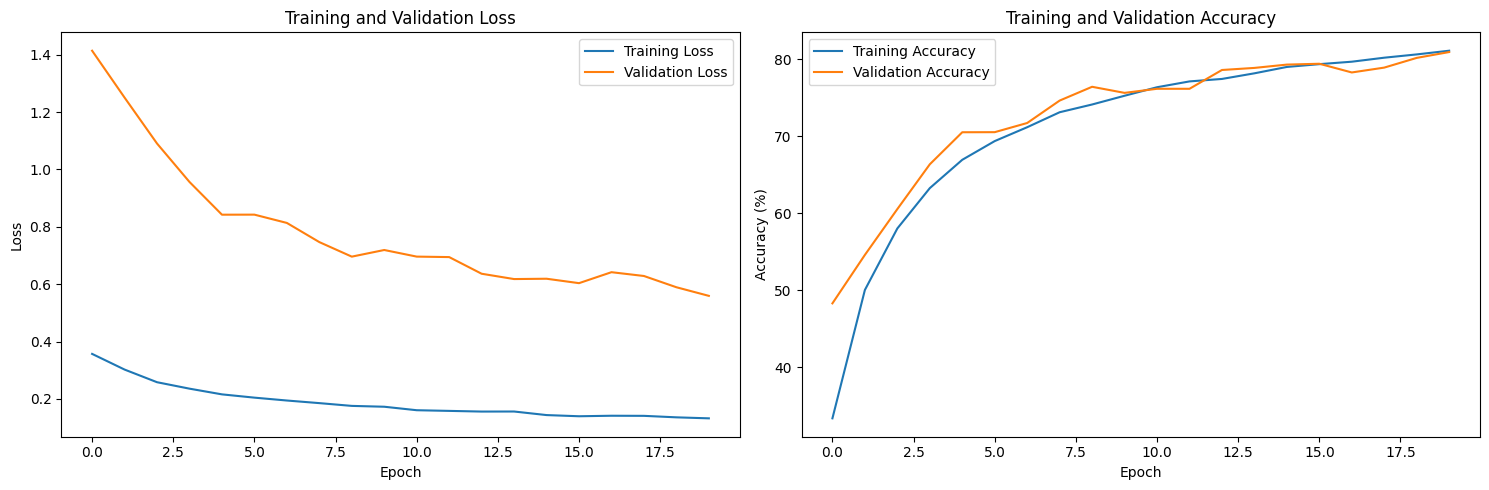

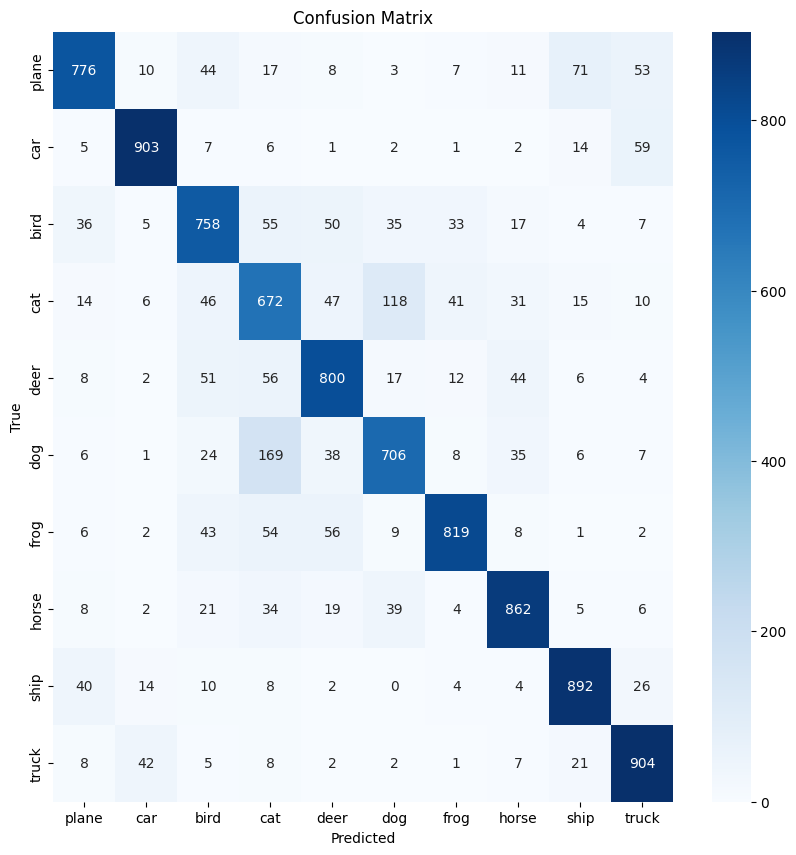

In [4]:
# CIFAR-10


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

#NUM_EPOCHS
num_epochs = 20

#  AlexNet model adapted for CIFAR-10
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Calculate epoch training metrics
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate epoch validation metrics
    epoch_test_loss = val_loss / len(testloader)
    epoch_test_acc = 100 * correct / total
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

print('Finished Training')

# print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal number of parameters: {total_params:,}')

# trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params:,}')


# Plotting the curves
plt.figure(figsize=(15, 5))

# plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Plot confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
# Calculate precision, recall, f1-score for each class
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%\n")
print("Per-class metrics:")
print("Class\t\tPrecision\tRecall\t\tF1-Score")
print("-" * 60)
for i in range(len(classes)):
    print(f"{classes[i]:<12}\t{precision[i]*100:>8.2f}%\t{recall[i]*100:>8.2f}%\t{f1[i]*100:>8.2f}%")
macro_precision = precision.mean()
macro_recall = recall.mean() 
macro_f1 = f1.mean()
print("\nMacro-averaged metrics:")
print(f"Precision: {macro_precision*100:.2f}%")
print(f"Recall: {macro_recall*100:.2f}%") 
print(f"F1-Score: {macro_f1*100:.2f}%")



Epoch [1/50], Step [100/391], Loss: 4.3987, Acc: 3.55%
Epoch [1/50], Step [200/391], Loss: 3.9365, Acc: 6.06%
Epoch [1/50], Step [300/391], Loss: 3.6848, Acc: 8.01%
Epoch [1/50] Test Accuracy: 17.03%
Epoch [2/50], Step [100/391], Loss: 3.3500, Acc: 18.34%
Epoch [2/50], Step [200/391], Loss: 3.2556, Acc: 18.97%
Epoch [2/50], Step [300/391], Loss: 3.0884, Acc: 19.90%
Epoch [2/50] Test Accuracy: 28.93%
Epoch [3/50], Step [100/391], Loss: 2.8651, Acc: 26.86%
Epoch [3/50], Step [200/391], Loss: 2.8491, Acc: 27.10%
Epoch [3/50], Step [300/391], Loss: 2.7444, Acc: 27.79%
Epoch [3/50] Test Accuracy: 30.94%
Epoch [4/50], Step [100/391], Loss: 2.5746, Acc: 33.27%
Epoch [4/50], Step [200/391], Loss: 2.5471, Acc: 33.38%
Epoch [4/50], Step [300/391], Loss: 2.4992, Acc: 33.71%
Epoch [4/50] Test Accuracy: 34.41%
Epoch [5/50], Step [100/391], Loss: 2.3609, Acc: 36.74%
Epoch [5/50], Step [200/391], Loss: 2.3617, Acc: 36.88%
Epoch [5/50], Step [300/391], Loss: 2.3202, Acc: 37.31%
Epoch [5/50] Test Accur

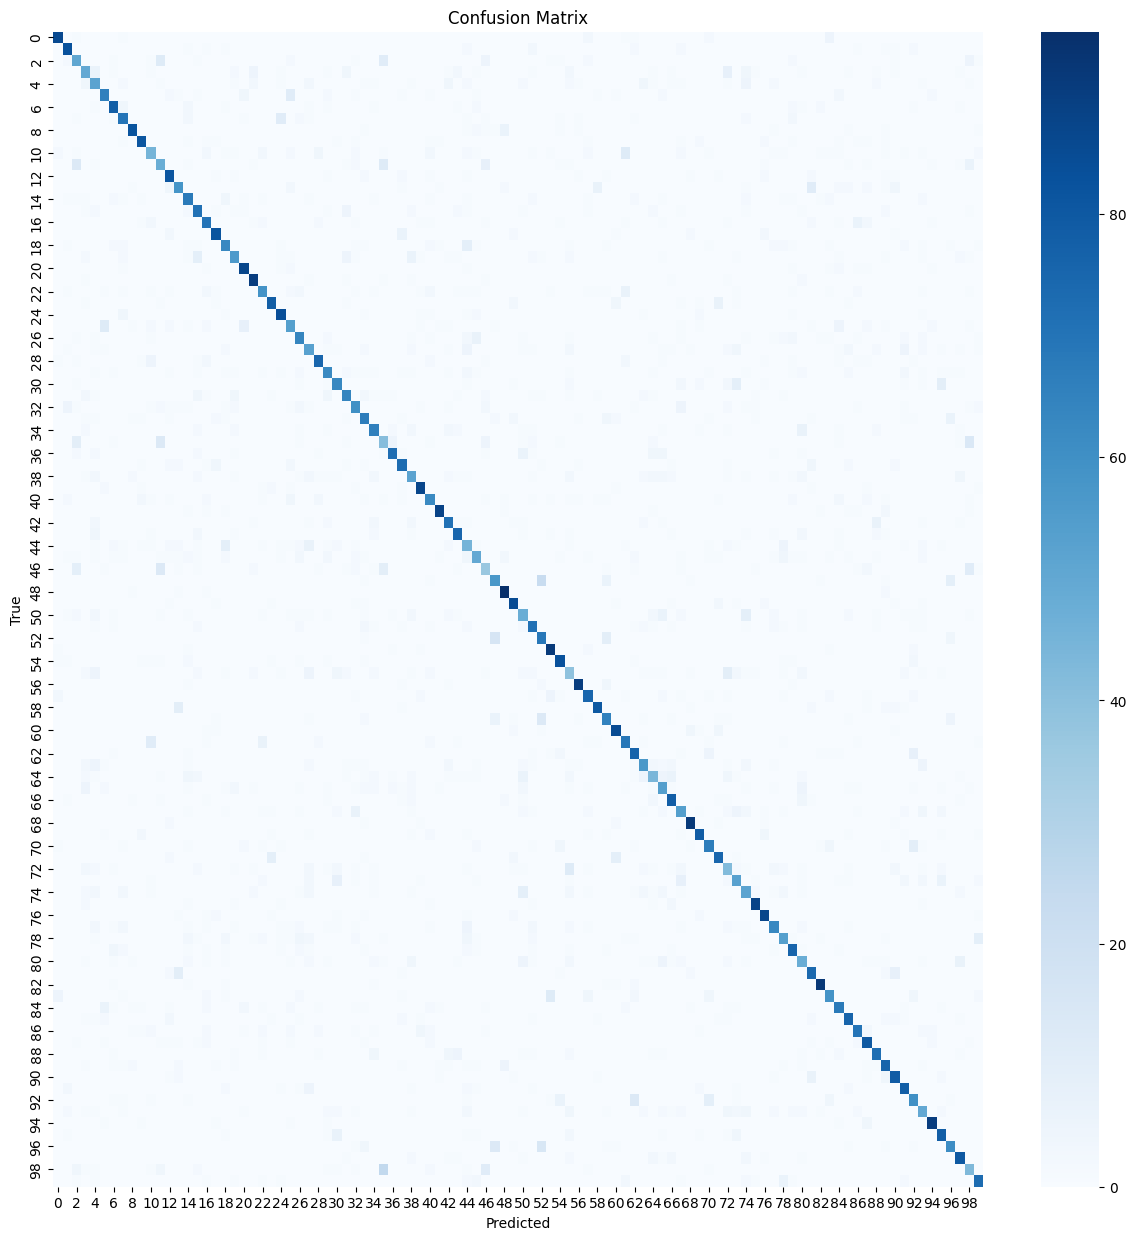

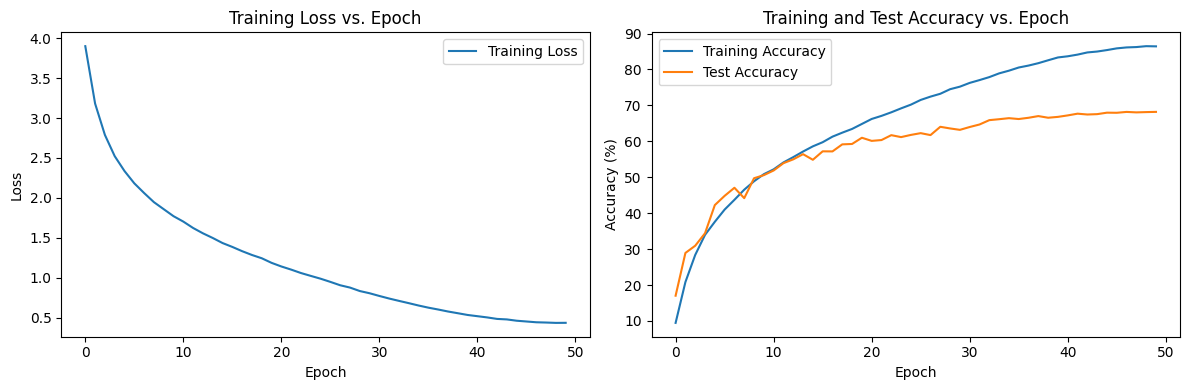

In [1]:
#CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=100).to(device)

# Training loop
num_epochs = 50 

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item() 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Compute confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Problem 2 (30 pts)

Repeat the problem 1 this time for VGGNet. Identify the VGG configuration that matches the nearest number of parameters to the AlexNet Architecture that you did for problem 1 for CIFAR-10 and CIFAR-100 datasets. Compare your training and evaluation results against AlexNet in Problem 1.

Here is a good reference guide to AlexNet: https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide
Links to an external site.

Links to an external site.

Explore the option of applying Dropout techniques for training your customized AlexNet. Compare the training and validation results against the baseline model without any dropout. Also, compare the results between CIFAR-10 and CIFAR-100.

Files already downloaded and verified
Files already downloaded and verified
Total Parameters: 33,646,666
Trainable Parameters: 33,646,666
Epoch [1/20], Step [100/391], Loss: 2.0779, Acc: 19.50%
Epoch [1/20], Step [200/391], Loss: 1.6966, Acc: 26.93%
Epoch [1/20], Step [300/391], Loss: 1.5091, Acc: 32.58%
Epoch [1/20] Test Accuracy: 52.88%
Epoch [2/20], Step [100/391], Loss: 1.2411, Acc: 54.93%
Epoch [2/20], Step [200/391], Loss: 1.1934, Acc: 56.38%
Epoch [2/20], Step [300/391], Loss: 1.0974, Acc: 57.69%
Epoch [2/20] Test Accuracy: 64.24%
Epoch [3/20], Step [100/391], Loss: 0.9544, Acc: 66.29%
Epoch [3/20], Step [200/391], Loss: 0.9109, Acc: 67.09%
Epoch [3/20], Step [300/391], Loss: 0.8765, Acc: 67.76%
Epoch [3/20] Test Accuracy: 72.72%
Epoch [4/20], Step [100/391], Loss: 0.7909, Acc: 72.55%
Epoch [4/20], Step [200/391], Loss: 0.7753, Acc: 72.75%
Epoch [4/20], Step [300/391], Loss: 0.7317, Acc: 73.47%
Epoch [4/20] Test Accuracy: 74.68%
Epoch [5/20], Step [100/391], Loss: 0.6762, Acc: 7

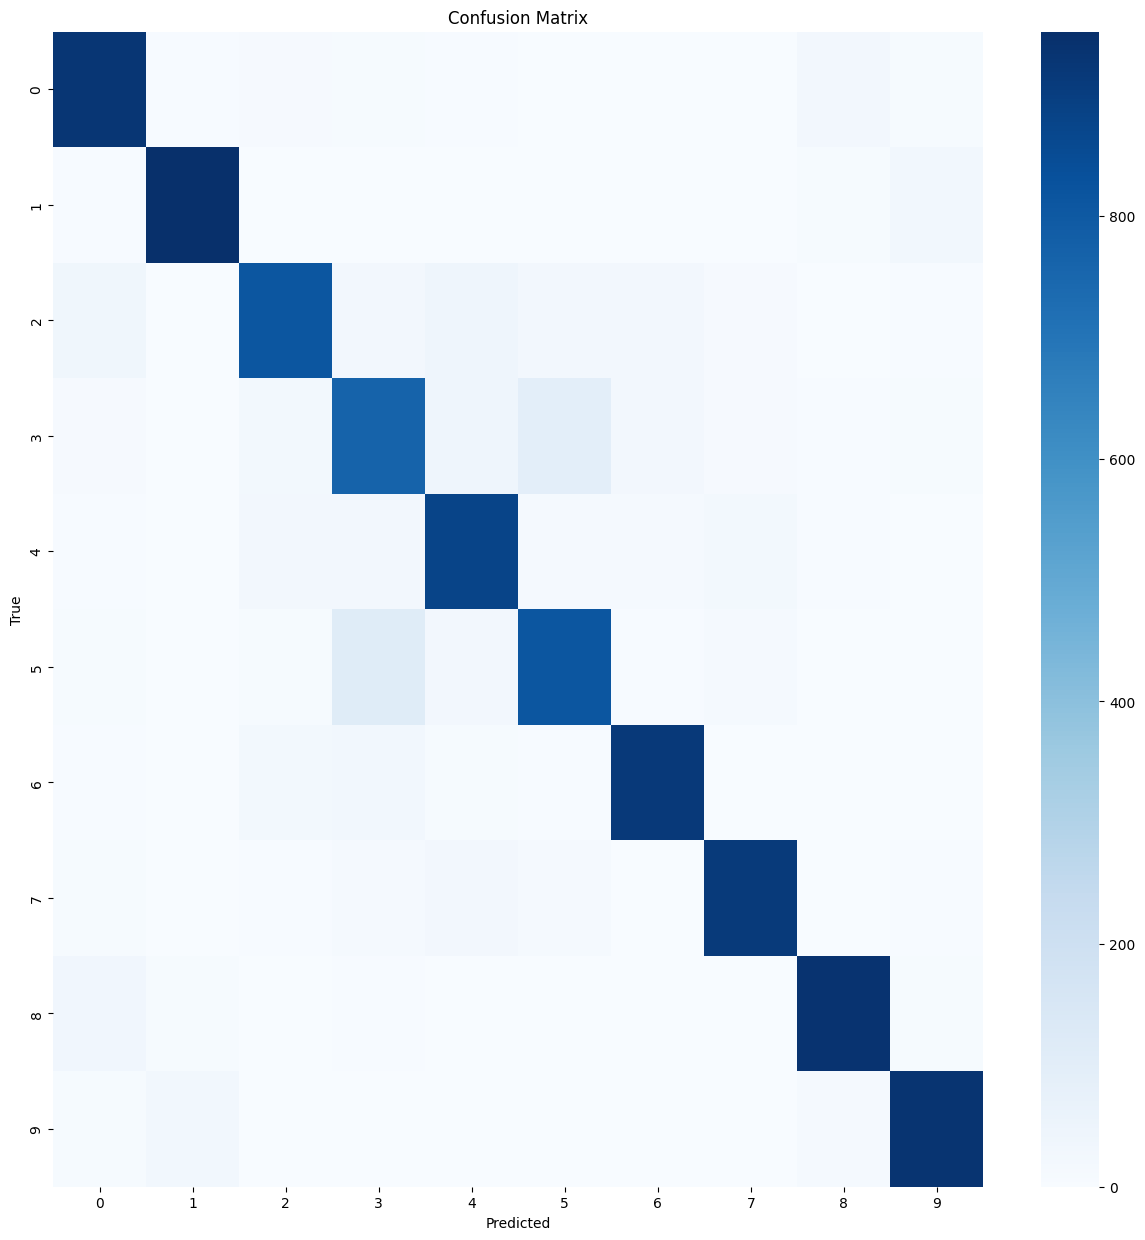

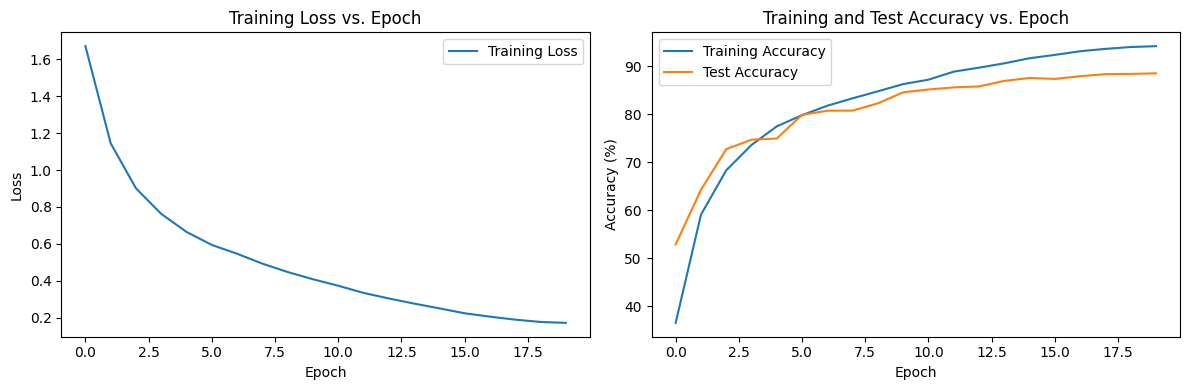

In [1]:
# CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# VGG16 for CIFAR-10 
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        # Block 1
        self.features = nn.Sequential(
            # Block 1 (64 channels)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2 (128 channels)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3 (256 channels)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4 (512 channels)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5 (512 channels)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 1 * 1, 4096),  # CIFAR-10 images are 32x32, after 5 max-pooling layers: 1x1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=10).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Total Parameters: 34,015,396
Trainable Parameters: 34,015,396
Epoch [1/20], Step [100/391], Loss: 4.5517, Acc: 1.58%
Epoch [1/20], Step [200/391], Loss: 4.3901, Acc: 2.17%
Epoch [1/20], Step [300/391], Loss: 4.1905, Acc: 3.07%
Epoch [1/20] Test Accuracy: 7.99%
Epoch [2/20], Step [100/391], Loss: 3.8684, Acc: 8.73%
Epoch [2/20], Step [200/391], Loss: 3.7471, Acc: 9.30%
Epoch [2/20], Step [300/391], Loss: 3.6758, Acc: 10.21%
Epoch [2/20] Test Accuracy: 13.72%
Epoch [3/20], Step [100/391], Loss: 3.4510, Acc: 15.26%
Epoch [3/20], Step [200/391], Loss: 3.4090, Acc: 15.54%
Epoch [3/20], Step [300/391], Loss: 3.3117, Acc: 16.16%
Epoch [3/20] Test Accuracy: 21.06%
Epoch [4/20], Step [100/391], Loss: 3.1266, Acc: 20.76%
Epoch [4/20], Step [200/391], Loss: 3.1153, Acc: 20.70%
Epoch [4/20], Step [300/391], Loss: 3.0024, Acc: 21.64%
Epoch [4/20] Test Accuracy: 24.50%
Epoch [5/20], Step [100/391], Loss: 2.8334

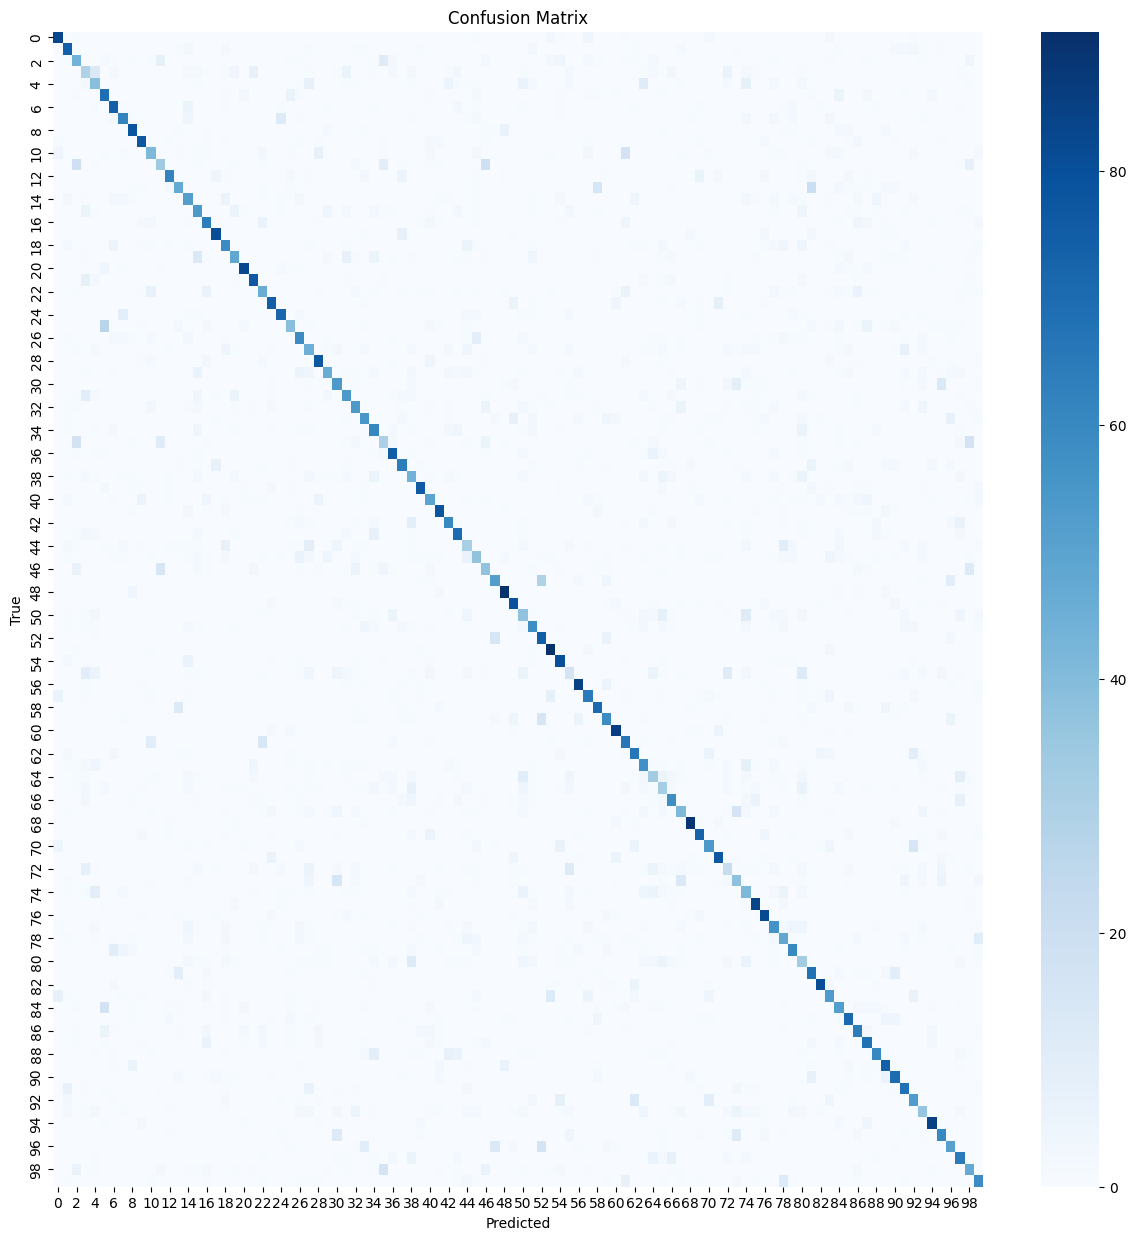

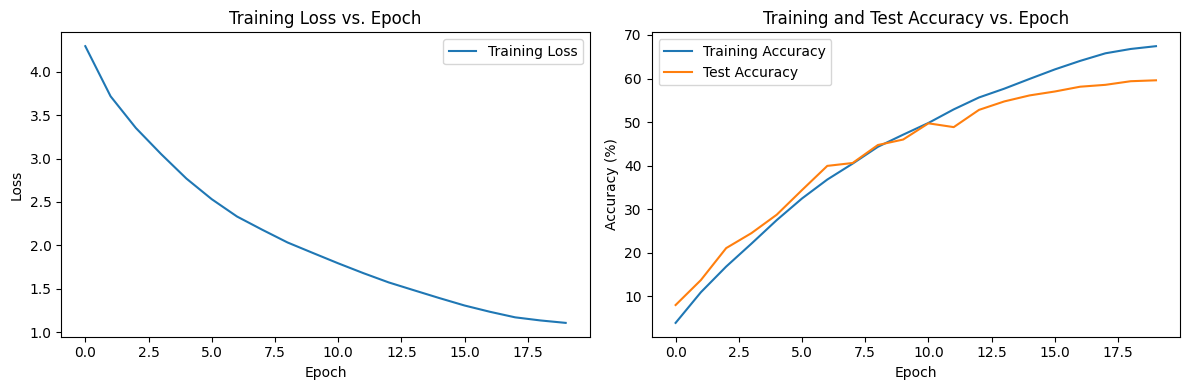

In [2]:
# CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")
num_epochs = 20

# VGG16 for CIFAR-100
class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        # Block 1
        self.features = nn.Sequential(
            # Block 1 (64 channels)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2 (128 channels)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3 (256 channels)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4 (512 channels)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5 (512 channels)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 1 * 1, 4096),  # CIFAR-100 images are 32x32, after 5 max-pooling layers: 1x1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Problem 3 (40 pts)

The baseline model we did in lectures is called ResNet-11. Build a new version of ResNet (ResNet-18). Train it on CIFAR-10 and CIFAR-100 datasets. Plot the training loss, validation loss, and validation accuracy. Compare the classification accuracy, and model size across the two versions of ResNet (11, 18). How does the complexity grow as you increase the network depth?

You can find some references for ResNet 18 here:

https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch

Links to an external site.

Explore the dropout option for the two networks and report your training results and validation accuracy. Also, compare the results between CIFAR-10 and CIFAR-100.

Files already downloaded and verified
Files already downloaded and verified
Total Parameters: 4,903,242
Trainable Parameters: 4,903,242
Epoch [1/20], Step [100/391], Loss: 1.9310, Acc: 26.66%
Epoch [1/20], Step [200/391], Loss: 1.6183, Acc: 32.38%
Epoch [1/20], Step [300/391], Loss: 1.4944, Acc: 36.53%
Epoch [1/20] Test Accuracy: 50.63%
Epoch [2/20], Step [100/391], Loss: 1.2966, Acc: 52.91%
Epoch [2/20], Step [200/391], Loss: 1.2239, Acc: 54.39%
Epoch [2/20], Step [300/391], Loss: 1.1534, Acc: 55.65%
Epoch [2/20] Test Accuracy: 61.39%
Epoch [3/20], Step [100/391], Loss: 1.0483, Acc: 62.79%
Epoch [3/20], Step [200/391], Loss: 1.0128, Acc: 63.07%
Epoch [3/20], Step [300/391], Loss: 0.9782, Acc: 63.65%
Epoch [3/20] Test Accuracy: 65.70%
Epoch [4/20], Step [100/391], Loss: 0.8886, Acc: 68.77%
Epoch [4/20], Step [200/391], Loss: 0.8793, Acc: 68.67%
Epoch [4/20], Step [300/391], Loss: 0.8601, Acc: 68.86%
Epoch [4/20] Test Accuracy: 69.72%
Epoch [5/20], Step [100/391], Loss: 0.7942, Acc: 71.

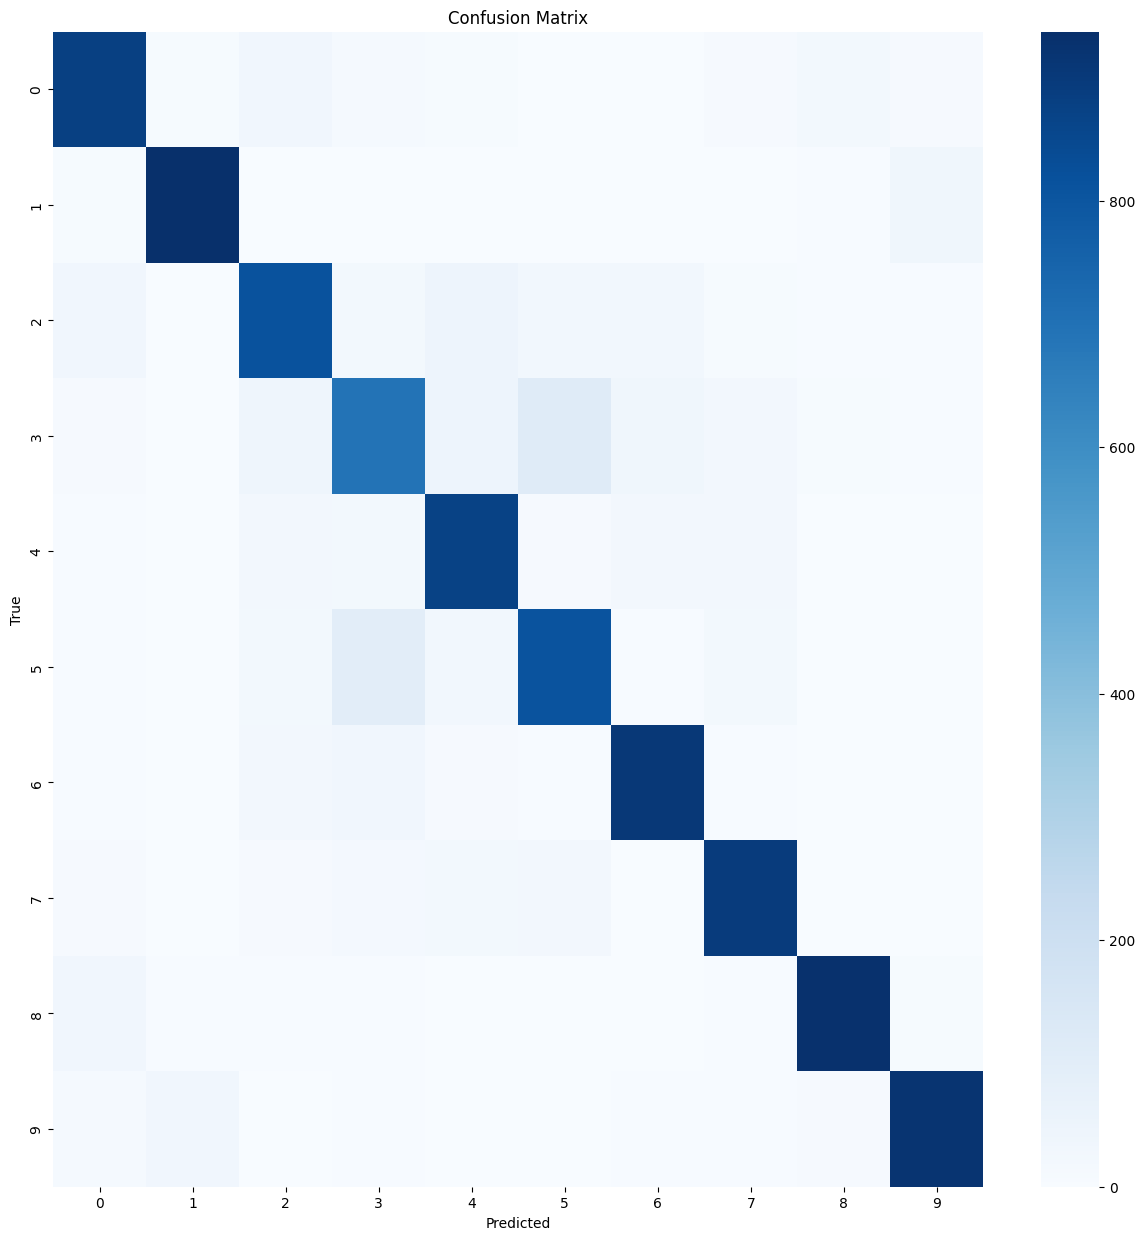

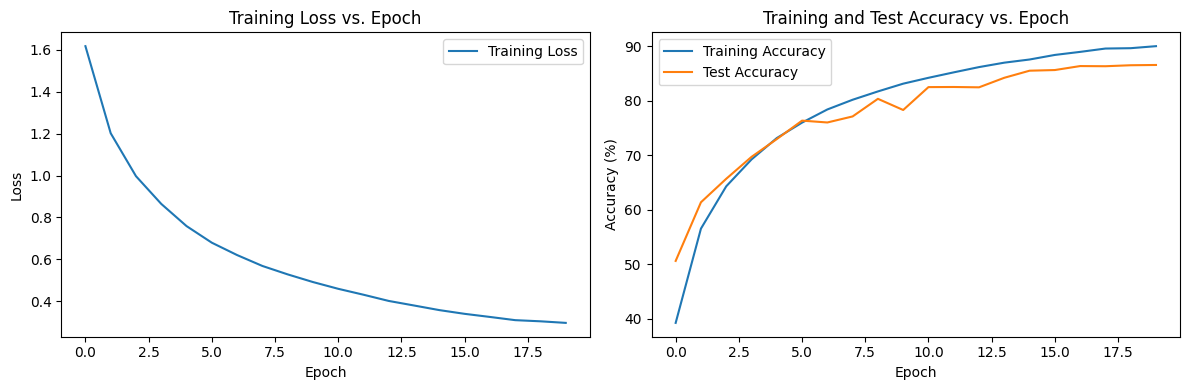

In [3]:
# CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet11
class ResNet11(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet11, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet blocks
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)
        self.layer4 = BasicBlock(256, 512, stride=2)
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=10).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Plot confusion matrix
confmat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(confmat, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Total Parameters: 4,949,412
Trainable Parameters: 4,949,412
Epoch [1/20], Step [100/391], Loss: 4.3557, Acc: 4.27%
Epoch [1/20], Step [200/391], Loss: 3.9958, Acc: 6.55%
Epoch [1/20], Step [300/391], Loss: 3.8001, Acc: 8.03%
Epoch [1/20] Test Accuracy: 12.87%
Epoch [2/20], Step [100/391], Loss: 3.5660, Acc: 15.13%
Epoch [2/20], Step [200/391], Loss: 3.4644, Acc: 15.85%
Epoch [2/20], Step [300/391], Loss: 3.3668, Acc: 16.77%
Epoch [2/20] Test Accuracy: 20.27%
Epoch [3/20], Step [100/391], Loss: 3.1885, Acc: 21.69%
Epoch [3/20], Step [200/391], Loss: 3.1049, Acc: 22.34%
Epoch [3/20], Step [300/391], Loss: 2.9979, Acc: 23.16%
Epoch [3/20] Test Accuracy: 24.97%
Epoch [4/20], Step [100/391], Loss: 2.8422, Acc: 28.44%
Epoch [4/20], Step [200/391], Loss: 2.7708, Acc: 29.14%
Epoch [4/20], Step [300/391], Loss: 2.7434, Acc: 29.36%
Epoch [4/20] Test Accuracy: 29.49%
Epoch [5/20], Step [100/391], Loss: 2.5992, Acc: 32.88%

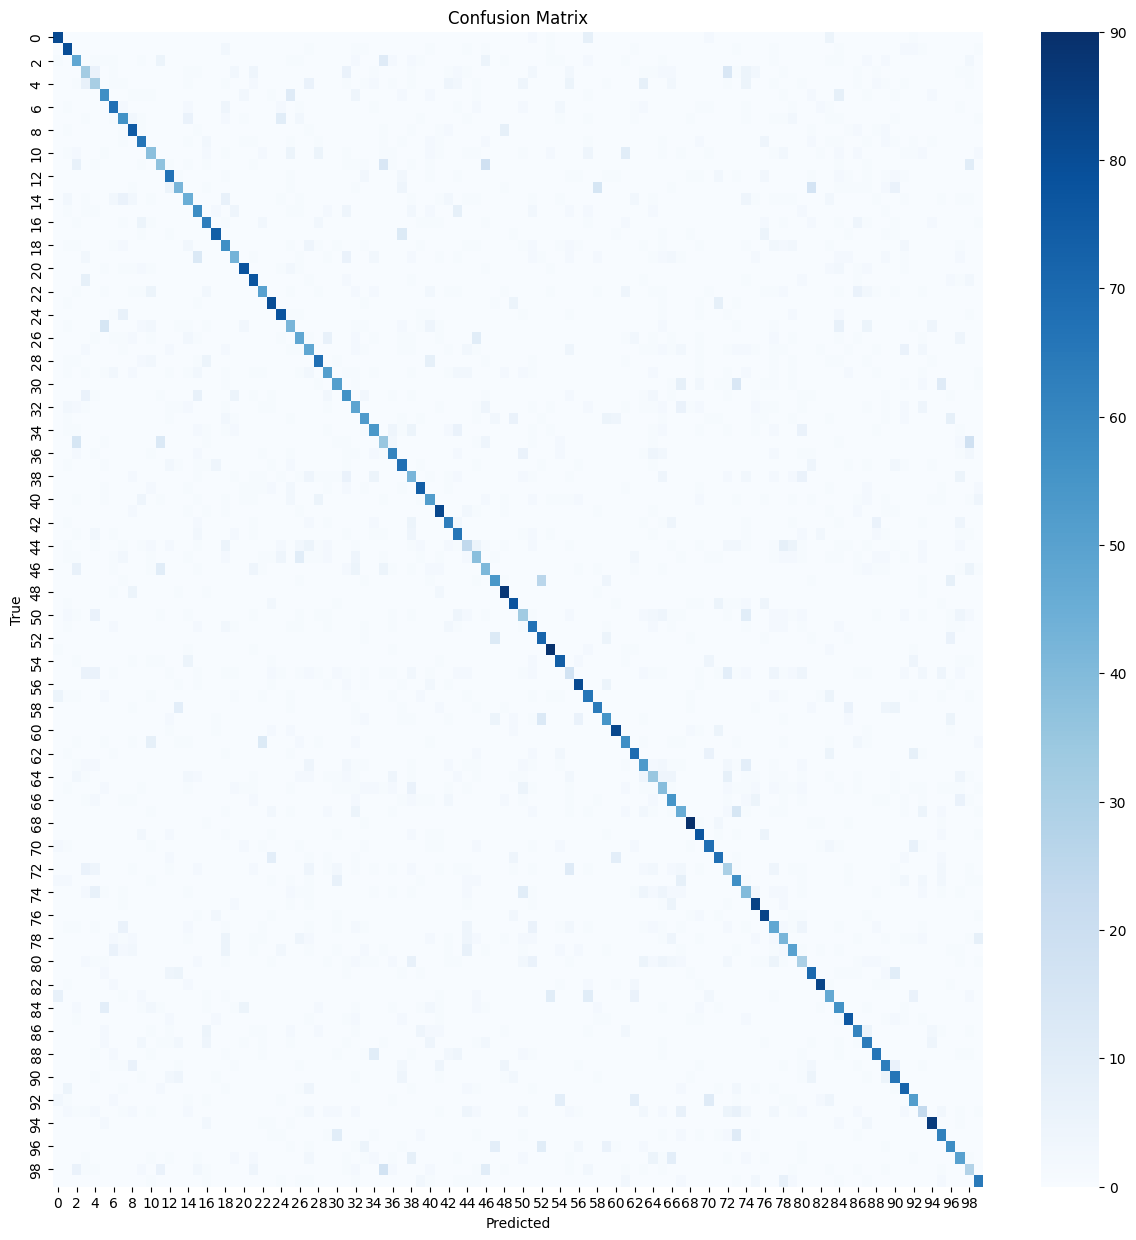

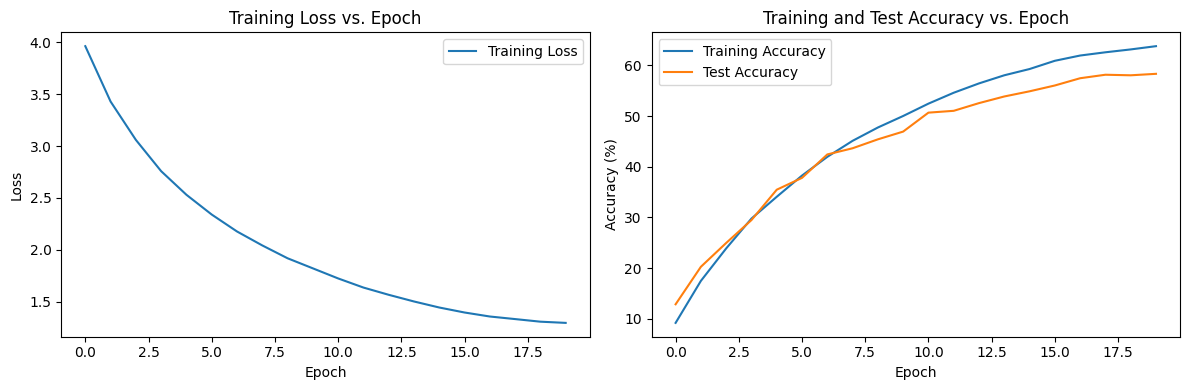

In [4]:
# CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")
# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet11
class ResNet11(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet11, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet blocks
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)
        self.layer4 = BasicBlock(256, 512, stride=2)
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Plot confusion matrix
cmatrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cmatrix, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Total Parameters: 11,173,962
Trainable Parameters: 11,173,962
Epoch [1/20], Step [100/391], Loss: 1.9668, Acc: 25.55%
Epoch [1/20], Step [200/391], Loss: 1.6524, Acc: 31.31%
Epoch [1/20], Step [300/391], Loss: 1.4887, Acc: 35.94%
Epoch [1/20] Test Accuracy: 52.52%
Epoch [2/20], Step [100/391], Loss: 1.2326, Acc: 55.59%
Epoch [2/20], Step [200/391], Loss: 1.1835, Acc: 56.34%
Epoch [2/20], Step [300/391], Loss: 1.1015, Acc: 57.88%
Epoch [2/20] Test Accuracy: 62.84%
Epoch [3/20], Step [100/391], Loss: 0.9572, Acc: 65.84%
Epoch [3/20], Step [200/391], Loss: 0.9253, Acc: 66.39%
Epoch [3/20], Step [300/391], Loss: 0.8600, Acc: 67.48%
Epoch [3/20] Test Accuracy: 64.54%
Epoch [4/20], Step [100/391], Loss: 0.7671, Acc: 73.02%
Epoch [4/20], Step [200/391], Loss: 0.7526, Acc: 73.24%
Epoch [4/20], Step [300/391], Loss: 0.7020, Acc: 73.95%
Epoch [4/20] Test Accuracy: 72.11%
Epoch [5/20], Step [100/391], Loss: 0.6468, Acc: 7

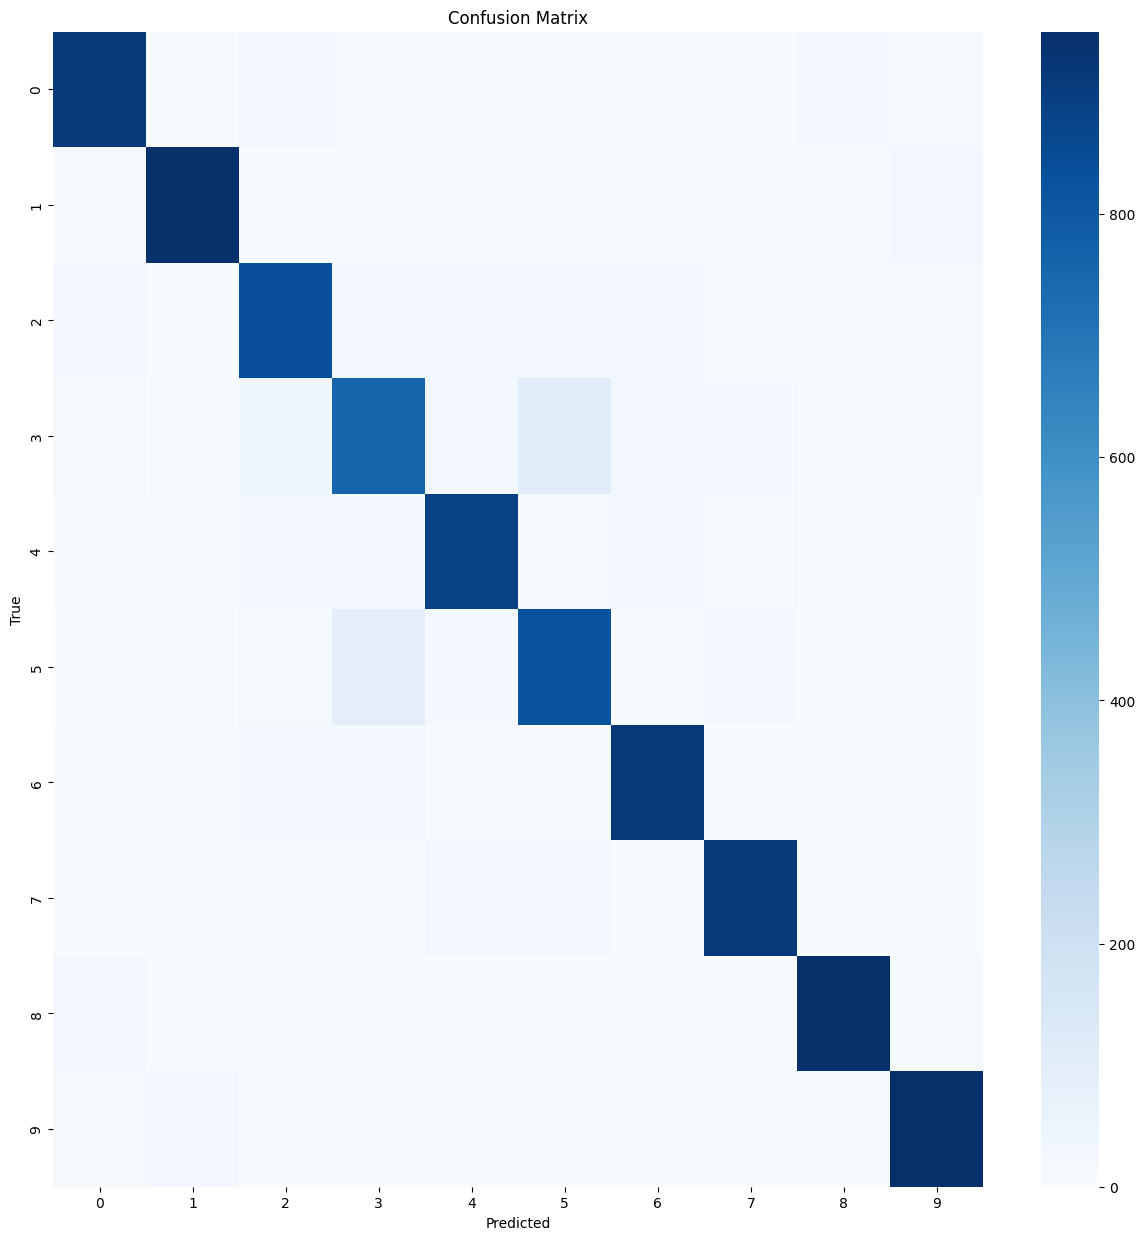

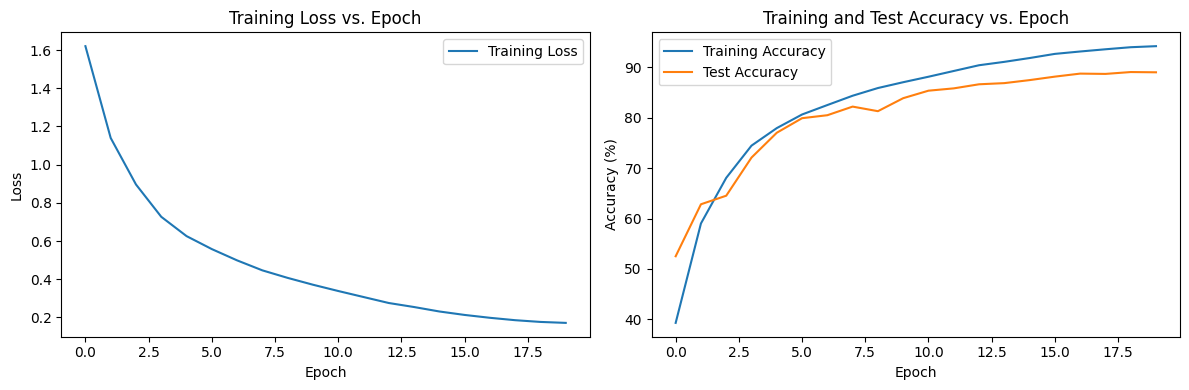

In [5]:
# ResNet18 - CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet18
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet layers
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=10).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Replace the confusion matrix section with:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Total Parameters: 11,220,132
Trainable Parameters: 11,220,132
Epoch [1/20], Step [100/391], Loss: 4.4315, Acc: 3.10%
Epoch [1/20], Step [200/391], Loss: 3.9913, Acc: 5.57%
Epoch [1/20], Step [300/391], Loss: 3.7810, Acc: 7.48%
Epoch [1/20] Test Accuracy: 15.45%
Epoch [2/20], Step [100/391], Loss: 3.4963, Acc: 15.81%
Epoch [2/20], Step [200/391], Loss: 3.3752, Acc: 16.93%
Epoch [2/20], Step [300/391], Loss: 3.2489, Acc: 18.16%
Epoch [2/20] Test Accuracy: 21.04%
Epoch [3/20], Step [100/391], Loss: 3.0389, Acc: 24.28%
Epoch [3/20], Step [200/391], Loss: 2.8948, Acc: 25.34%
Epoch [3/20], Step [300/391], Loss: 2.8424, Acc: 26.22%
Epoch [3/20] Test Accuracy: 29.74%
Epoch [4/20], Step [100/391], Loss: 2.6331, Acc: 31.64%
Epoch [4/20], Step [200/391], Loss: 2.5488, Acc: 32.38%
Epoch [4/20], Step [300/391], Loss: 2.5108, Acc: 32.94%
Epoch [4/20] Test Accuracy: 34.59%
Epoch [5/20], Step [100/391], Loss: 2.3146, Acc: 38.4

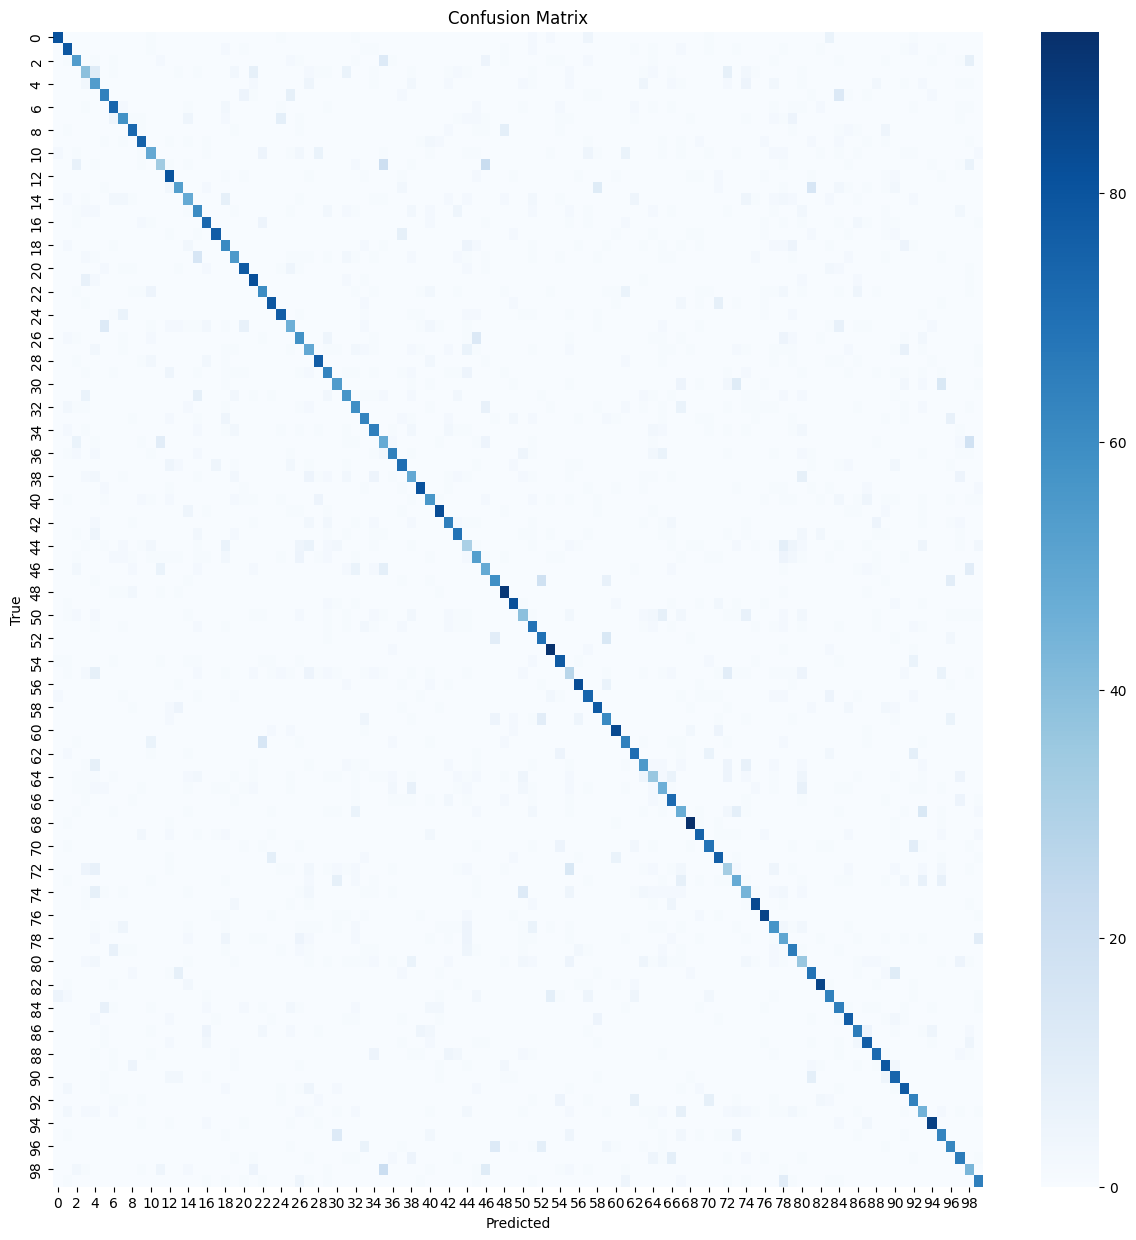

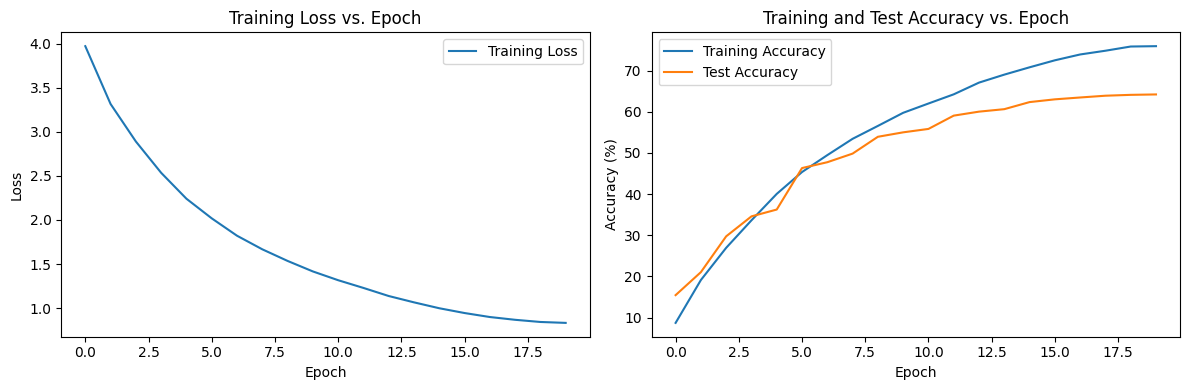

In [6]:
# ResNet11 - CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np
num_epochs = 20

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# Basic ResNet block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

# ResNet18
class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet layers
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=100).to(device)

# After model definition but before training loop
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

# Training loop


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')


model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'\nModel Performance Metrics:')
print(f'F1 Score (macro): {f1:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'Precision (macro): {precision:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
